In [1]:
# Import packages
import os,sys
from glob import glob
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import fiona
import rasterio as rio

from pysptools.material_count.vd import HfcVd
import pysptools.eea as eea 
import pysptools.abundance_maps as amap
import pysptools.classification as cls
import pysptools.material_count as cnt

from scipy.stats.stats import pearsonr

from earthpy.spatial import bytescale
import earthpy as et

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

In [2]:
# Download wavelength and stacked aoi array data 
url_wavelengths_sagebursh = 'https://ndownloader.figshare.com/files/23262752'
et.data.get_data(url=url_wavelengths_sagebursh, replace=True)

url_wavelengths_cheatgrass = 'https://ndownloader.figshare.com/files/23262755'
et.data.get_data(url=url_wavelengths_cheatgrass)

url_stacked_arr = 'https://ndownloader.figshare.com/files/23487062'
et.data.get_data(url=url_stacked_arr, replace=True)

Extracted output to C:\Users\Smells\earth-analytics\data\earthpy-downloads\S07LSAT8_Sagebrush_IH91-1B_BECKa_AREF


'C:\\Users\\Smells\\earth-analytics\\data\\earthpy-downloads\\stacked_aoi.tif'

In [3]:
# Set working directory and other paths
os.chdir(os.path.join(et.io.HOME, 'earth-analytics'))
stacked_aoi_path = os.path.join("data", "earthpy-downloads", "stacked_aoi.tif")

wavelength_path = os.path.join("data", "earthpy-downloads", 
                                "S07LSAT8_Sagebrush_IH91-1B_BECKa_AREF",
                                "S07LSAT8_Wavelengths_Landsat8_(7_bands)_nanos.txt")

sagebrush_wave_path = os.path.join("data", "earthpy-downloads", 
                                "S07LSAT8_Sagebrush_IH91-1B_BECKa_AREF",
                                "S07LSAT8_Sagebrush_IH91-1B_BECKa_AREF.txt")

cheatgrass_wave_path = os.path.join("data", "earthpy-downloads", 
                                "S07LSAT8_Cheatgrass_ANP92-11A_BECKa_AREF",
                                "S07LSAT8_Cheatgrass_ANP92-11A_BECKa_AREF.txt")

In [4]:
# Read Landsat 8 wavelength data as array
wavelengths_arr = np.loadtxt(wavelength_path, skiprows=1)
wavelengths_arr

# # Multiply by 1000 to convert to nanometers
# wavelengths_arr = wavelengths_micr_arr * 1000
# wavelengths_arr

sagebrush_wave = np.loadtxt(sagebrush_wave_path, skiprows=1)
cheatgrass_wave = np.loadtxt(cheatgrass_wave_path, skiprows=1)
cheatgrass_wave

array([0.05022632, 0.06345156, 0.08966763, 0.14481317, 0.33819094,
       0.33156845, 0.22529307])

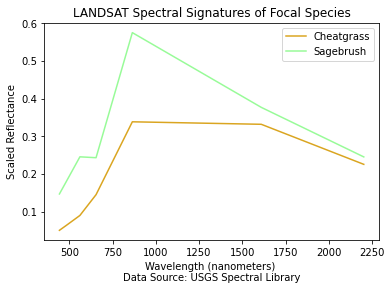

**************************************************
These spectral signatures are 87 percent similar.


In [5]:
# Plot sagebrush and cheatgrass spectral signatures
fig, ax = plt.subplots()
ax.plot(wavelengths_arr, cheatgrass_wave,
        color='goldenrod', label='Cheatgrass')
ax.plot(wavelengths_arr, sagebrush_wave,
        color='palegreen', label='Sagebrush')
ax.set_xlabel('Wavelength (nanometers) \n'
              'Data Source: USGS Spectral Library',
               fontsize=10)
ax.set_title('LANDSAT Spectral Signatures of Focal Species')
ax.set_ylabel('Scaled Reflectance')
plt.legend()
plt.show()
print('**************************************************')
print('These spectral signatures are',
      int(pearsonr(cheatgrass_wave,sagebrush_wave)[0]*100),
      'percent similar.')

In [6]:
# Compare the differences between signatures (score, p-value)
pearsonr(cheatgrass_wave, sagebrush_wave)

(0.8711049699544627, 0.010675231620522599)

In [7]:
# Open stacked array
with rio.open(stacked_aoi_path) as aoi:
    stacked_arr = aoi.read()
    stacked_meta = aoi.meta

print(stacked_arr.shape)

(7, 298, 397)


In [8]:
# Rearranging dimensions order to match HSI cube format
stacked_arr_rolled = np.rollaxis(stacked_arr, 0, 3)
print(stacked_arr_rolled.shape)

stacked_arr_transpose = np.transpose(stacked_arr, (2, 1, 0))
stacked_arr_transpose.shape

(298, 397, 7)


(397, 298, 7)

In [9]:
# Scale array for 0-1 reflectance (typical of spectral signatures)
stacked_arr_scaled = stacked_arr_rolled * 0.0001

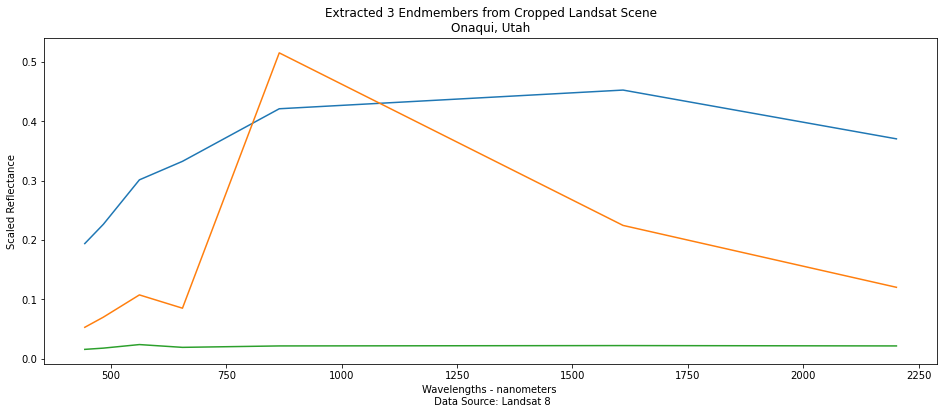

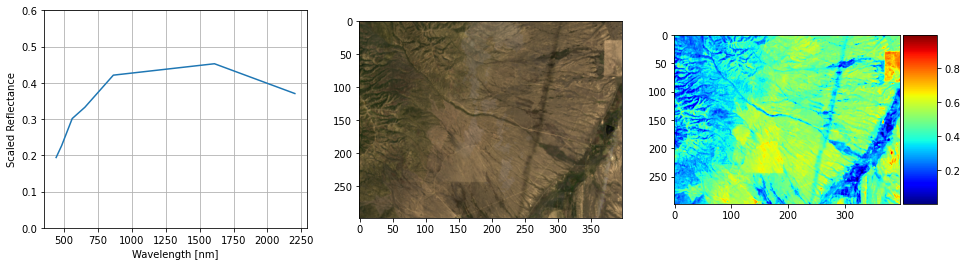

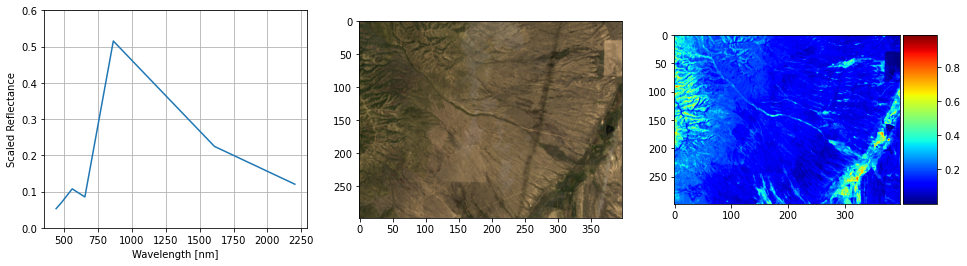

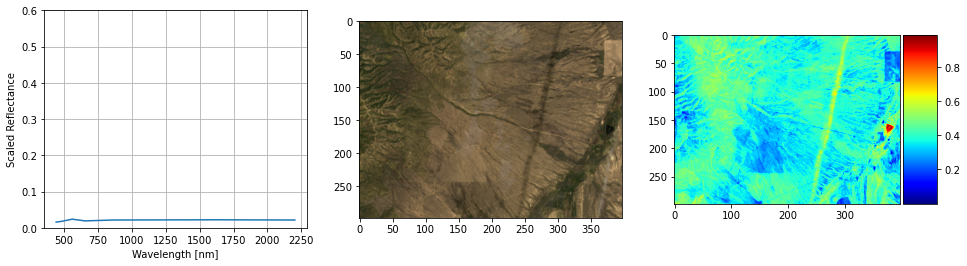

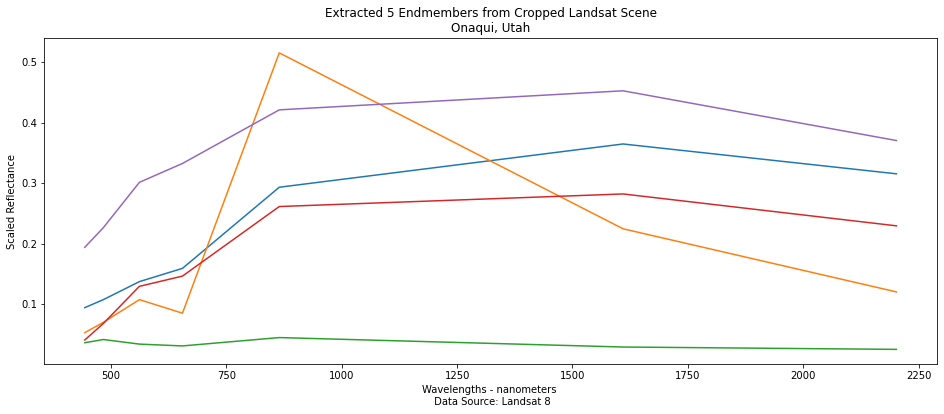

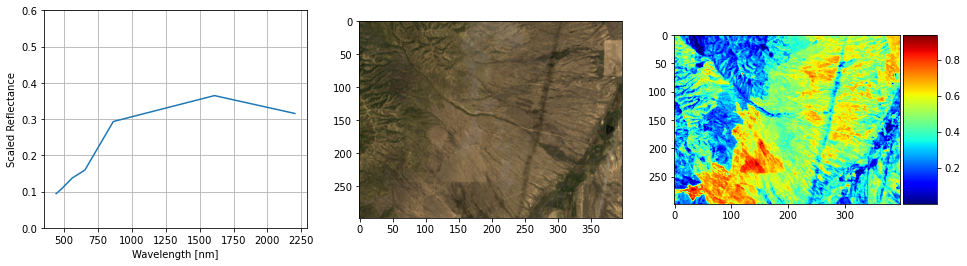

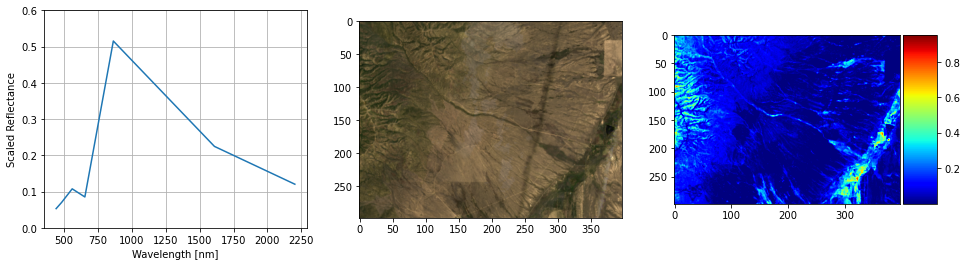

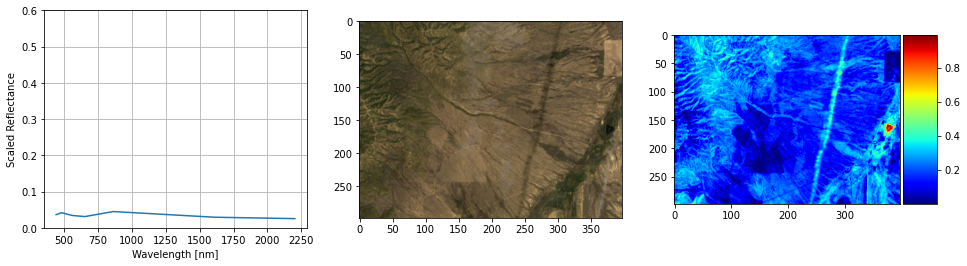

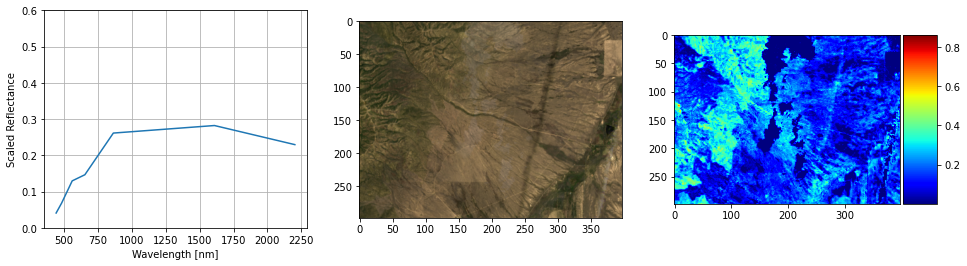

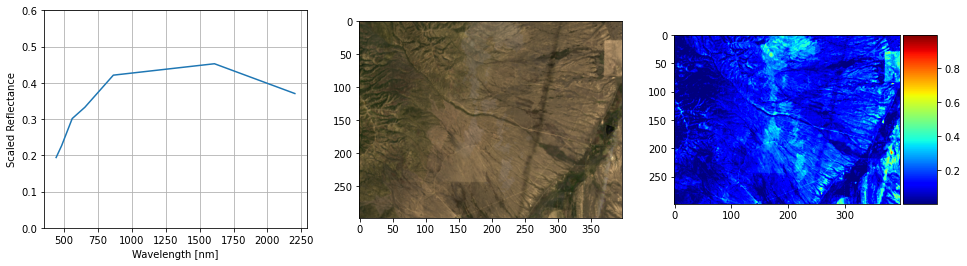

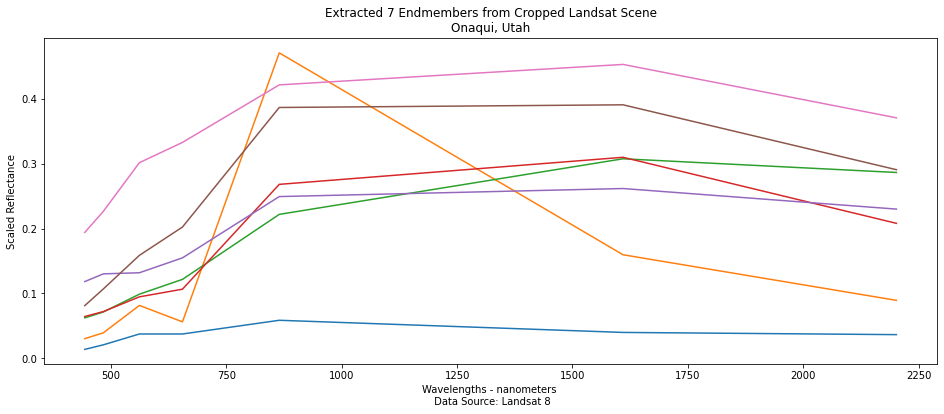

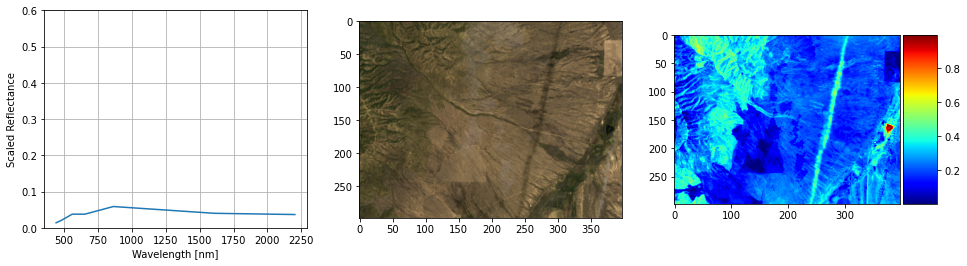

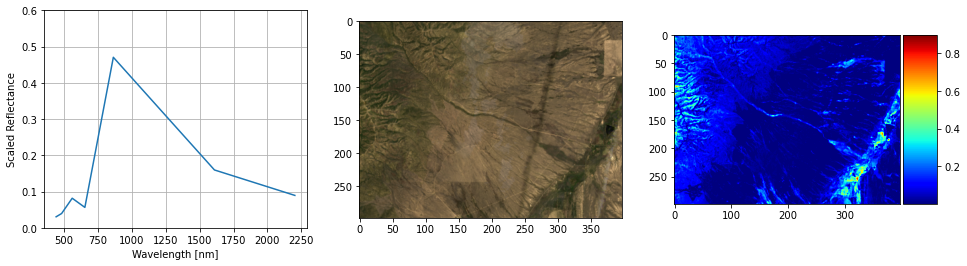

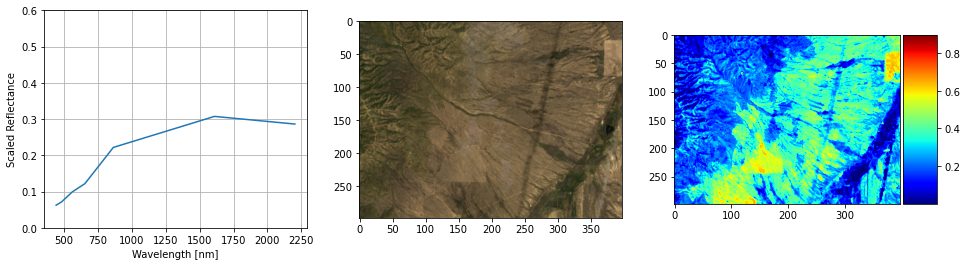

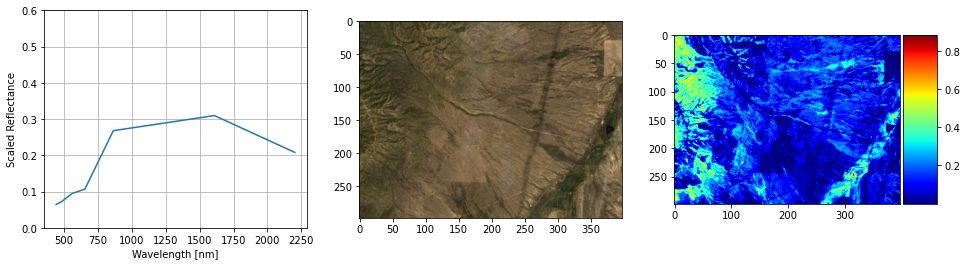

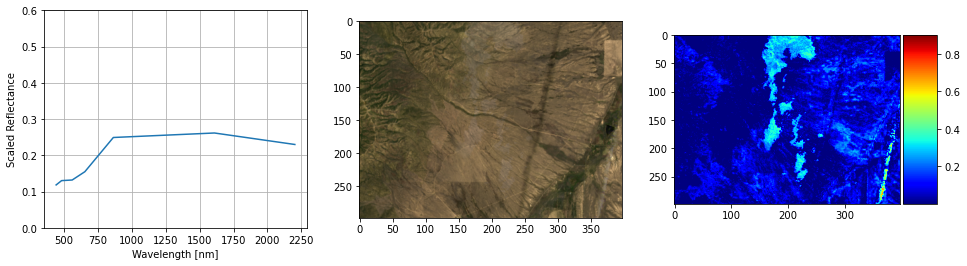

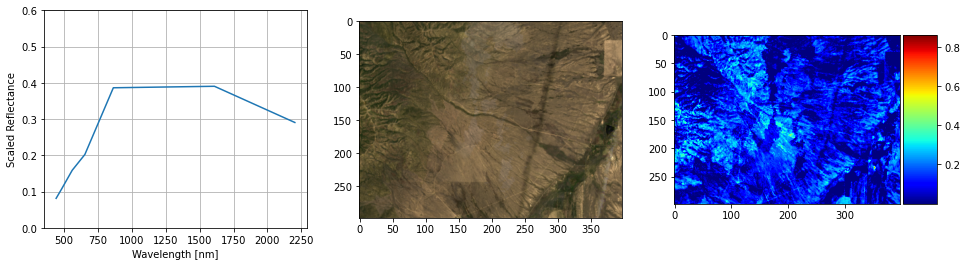

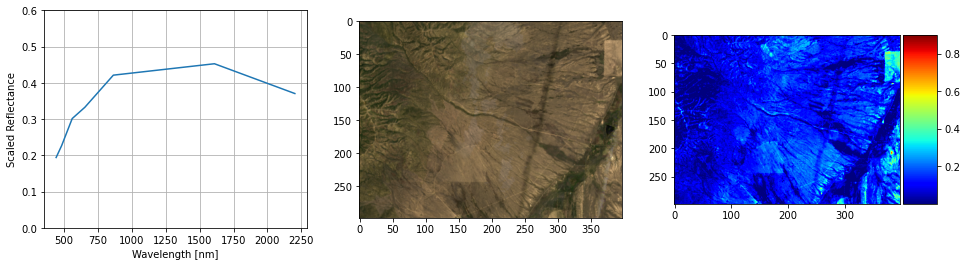

In [10]:
ee = eea.NFINDR()
U_results = []

for n_em in [3,5,7]:
    
    U = ee.extract(stacked_arr_scaled, n_em, maxit=10, normalize=False, ATGP_init=True)
    U_results.append(U)
    
    # plot them
    plt.figure(figsize=(16,6))
    for em in U:
        plt.plot(wavelengths_arr, em)
        
    plt.title(f'Extracted {n_em} Endmembers from Cropped Landsat Scene\nOnaqui, Utah')
#     plt.figure(figsize=(16,6))
    plt.xlabel('Wavelengths - nanometers \n Data Source: Landsat 8')
    plt.ylabel('Scaled Reflectance')
    plt.show()

    # Plot the abundance maps
    am = amap.FCLS()
    ab_maps = am.map(stacked_arr_rolled, U, normalize=True)
    
    for i,em in enumerate(U):
        fig = plt.figure(figsize=(16,4))
        gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1]) 

        ax0 = plt.subplot(gs[0])
        ax0.set(xlabel="Wavelength [nm]", ylabel="Scaled Reflectance")
        ax0.set_ylim([0, 0.6])
        
        p0 = ax0.plot(wavelengths_arr, em)
        ax0.grid(True)

        ax1 = plt.subplot(gs[1])
        #ax1.set(xlabel="Pixel Number (West-to-East)", ylabel="Pixel Number (South to North)")
        im1 = ax1.imshow(bytescale(stacked_arr_rolled[:,:,[3,2,1]]))

        ax2 = plt.subplot(gs[2])
        im2 = ax2.imshow(ab_maps[:,:,i], cmap='jet')

        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="15%", pad=0.05)
        
        
        plt.ylim(0,0.6)       
        plt.colorbar(im2, cax=cax)
        plt.show()


In [11]:
coefficient_sagebrush = []
coefficient_cheatgrass = []

# Compare known wavelengths with ee
for i in range(0,U.shape[0]):
    coefficient_sagebrush.append(pearsonr(
        sagebrush_wave,U[i])[0])
    coefficient_cheatgrass.append(pearsonr(
        cheatgrass_wave,U[i])[0])

In [12]:
coefficient_sagebrush

[0.9081859336823468,
 0.9680761966717595,
 0.5889916693214721,
 0.8023495087836547,
 0.7776637708485322,
 0.8550802498862813,
 0.7973566381198215]

In [13]:
coefficient_cheatgrass

[0.8159663182360464,
 0.7640970708694762,
 0.8963633742695187,
 0.9830112744651044,
 0.9795224582731813,
 0.9950762774025605,
 0.953459500090426]